# Mentoria DiploDatos 2022 - Clasificación de Señales Intracraneales de EEG en Pacientes Epilépticos

### Introducción
La epilepsia es un trastorno del sistema nervioso central (neurológico) en el que la actividad cerebral normal se altera, lo que provoca convulsiones o períodos de comportamiento y sensaciones inusuales, y a veces, pérdida de la consciencia. 

Cualquier persona puede padecer de epilepsia. La epilepsia afecta tanto a hombres como a mujeres de todas las razas, grupos étnicos y edades.
Los síntomas de las convulsiones pueden variar mucho. Algunas personas con epilepsia simplemente permanecen con la mirada fija por algunos segundos durante una convulsión, mientras que otras mueven repetidamente los brazos o las piernas.  
El tratamiento con medicamentos, o en ocasiones la cirugía, puede controlar las convulsiones en la mayoría de las personas que tienen epilepsia. Algunas personas requieren tratamiento de por vida para controlar las convulsiones. En la actualidad muchos grupos de investigación y empresas biotecnológicas del mundo  están intentando desarrollar instrumentos para poder controlar los ataques epilépticos. Un ejemplo es la  estimulación cerebral profunda (DBS), pero para la aplicación de cualquier dispositivo disuasivo primero es imprescindible poder detectar con antelación el ataque epileptico. 

Hay pruebas de que la dinámica temporal de la actividad cerebral en un paciente epileptico  puede  clasificarse en 4 estados: Inter-ictal (entre convulsiones, o línea de base), Prei-ctal (antes del ataque), Ictal (ataque epileptico en si) y Post-ictal (después de los ataques). La previsión de las convulsiones requiere la capacidad **diferenciar  de forma fiable un estado pre-ictal de los demás estados interictal, ictal y postictal**. El objetivo de estudiar  estos datos es demostrar la existencia y la clasificación precisa del estado cerebral preictal del interictal en humanos que padecen epilepsia.  

La actividad cerebral humana se registró en forma de electroencefalografía intracraneal (iEEG), que implica la colocación de electrodos en la superficie de la corteza cerebral y el registro de señales eléctricas con un sistema de monitorización ambulatoria. Los datos  iEEG se muestrearon a partir de 16 electrodos a 400 Hz, y los voltajes registrados se referenciaron a la media del grupo de electrodos.  

**En pocas palabras, la idea de esta mentoria consiste en distinguir entre  datos que registrados 10 minutos  antes de una convulsión, y datos de diez minutos de actividad interictal**. Se sabe que los ataques que se agrupan, o que se producen en grupos. Los pacientes que suelen tener grupos de convulsiones reciben poco beneficio de la previsión de las convulsiones siguientes. Para este base de datos, sólo las convulsiones principales, definidos aquí como los que ocurren cuatro horas o más después de otro ataque, se en los conjuntos de datos de entrenamiento y prueba. Para evitar cualquier posible contaminación entre las señales de EEG interictal, preictal y postictal, los segmentos de datos interictal interictales se restringieron a por lo menos cuatro horas antes o después de cualquier ataque. Los segmentos de datos interictales interictales se eligieron al azar dentro de estas restricciones.



### Preprocesamiento

A cada grupo de señales se las pre-procesaron y calcularon 8 cuantificadores que van desde estadística clásica (valor medio , desvío, estándar, etc), medidas de información (entropía, complejidad, etc ) y medidas de espectro de potencia (espectral entropy). 

Los datos consisten en 3 pacientes con dos carpeta cada uno: i) etiquetados (test) y no etiquetados. Los etiquetados muestan la etiqueta de 0 interictal y 1 pre-ictal (antes del ataque epileptico ).

Los todos los datos de las señales raw pueden descargarse de la pagina [Kanggle iEEG preictal](https://www.kaggle.com/c/melbourne-university-seizure-prediction/data)



##IMPORTANTE 

Lo que vamos a mostrar a continuación es el analisis para un solo file de un paciente , esto se hizo para todos archivos etiquetados y no etiquetados (mas de 6000 en total ) y **no es necesario que lo hagan nuevamente** ya que el proceso toma mucho tiempo. Los archivos que ustedes reciben son las series de tiempo **procesadas** y cada columna son metricas distintas que se explican a continuación.


## **Analisis de las series temporales de un paciente** 

Los datos originales se encuentan en MATLAB file por lo que es necesario utilizar el paquete scipy. A su vez cada archivo esta estructurado de manera que tenemos no solo las señales sino tambien la información de la adquisición de las mismas , como por ejemplo la frecuencia de sampleo.


In [ ]:
from   scipy.io      import loadmat
import matplotlib.pyplot as plt
import os 
from google.colab import drive

drive.mount('/content/drive')

#path = "/content/drive/My Drive/prueba/1_1_0.mat"

path= '/content/drive/MyDrive/Diplomatura 2022/Copia de 1_1_0.mat'
dataStruct=loadmat(path,squeeze_me=True,struct_as_record=False)['dataStruct']

print(dataStruct)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Podemos graficar las señales para tener una idea como se ven los datos 

Numero de datos 240000
Fecuencia de Sampleo 400.0
Numero de Canales 16


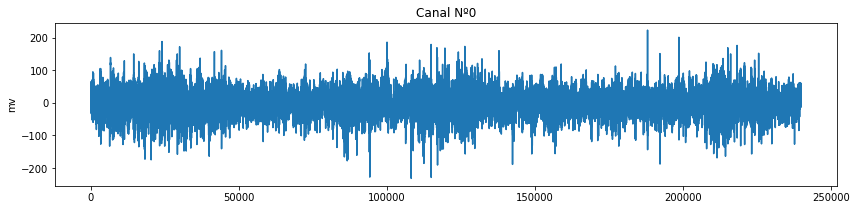

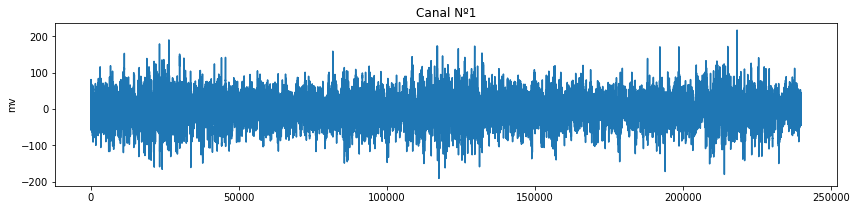

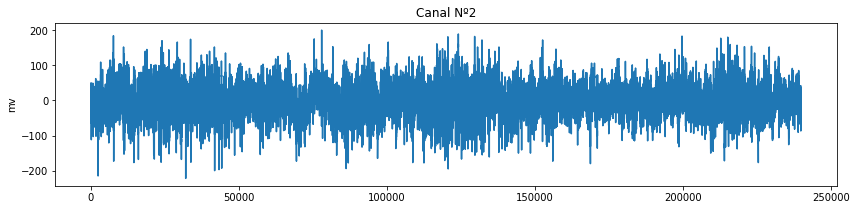

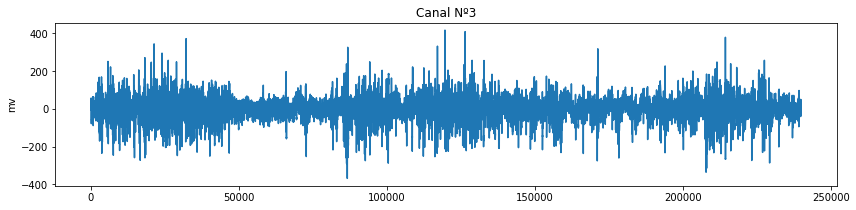

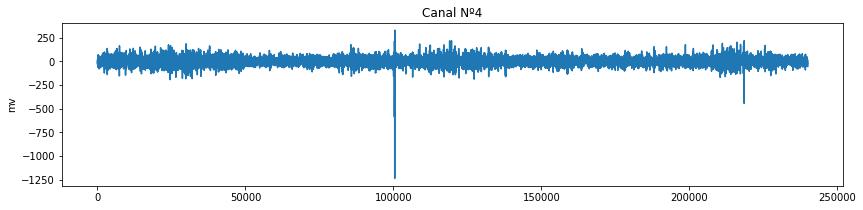

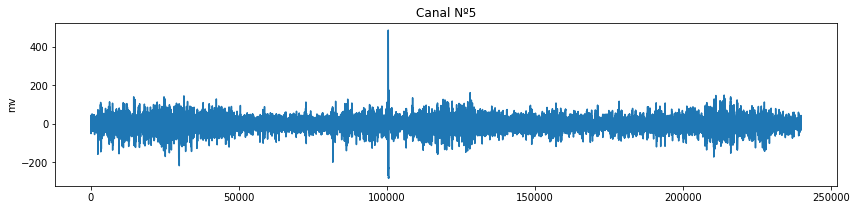

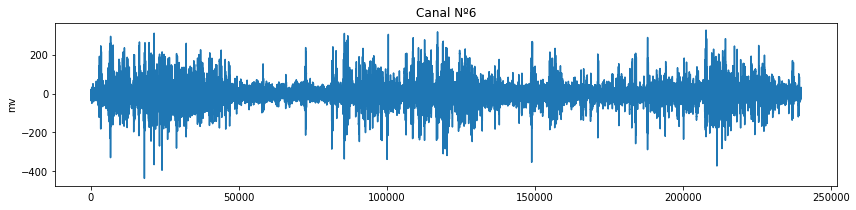

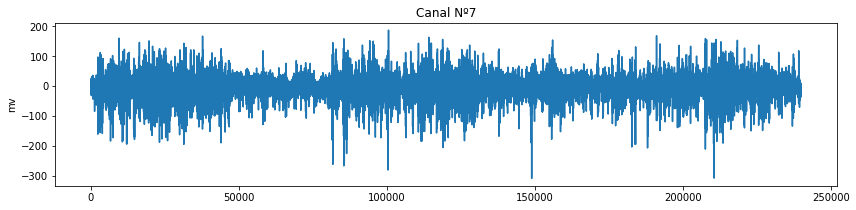

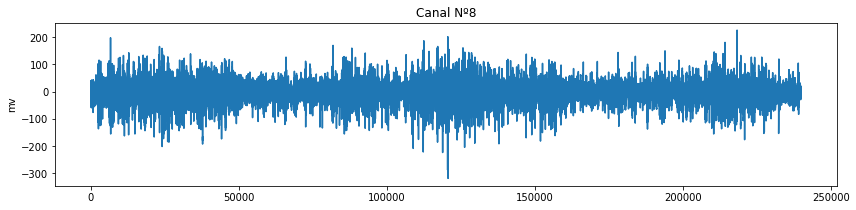

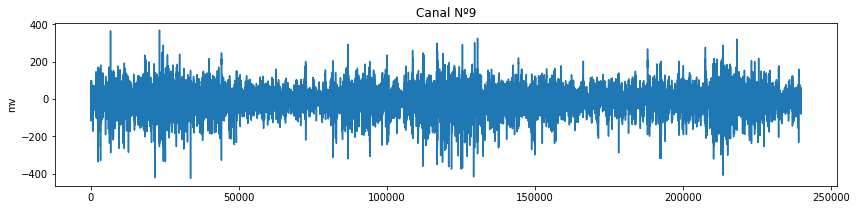

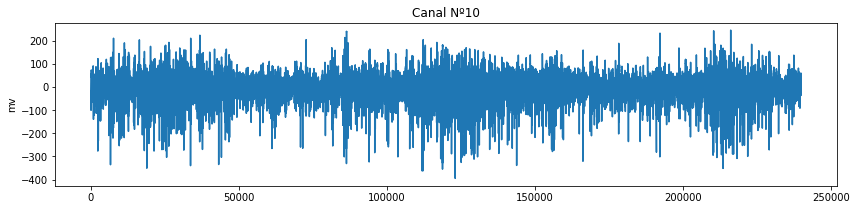

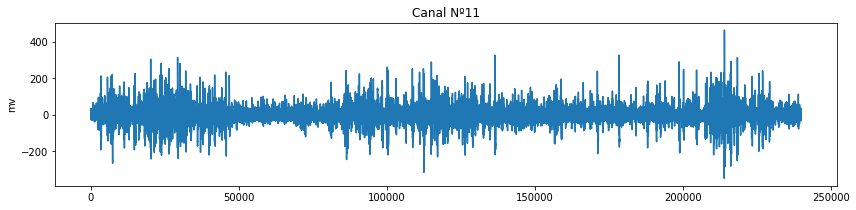

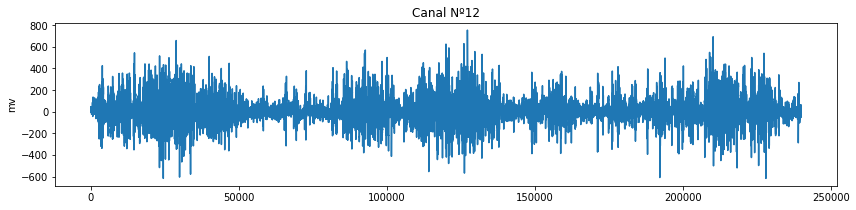

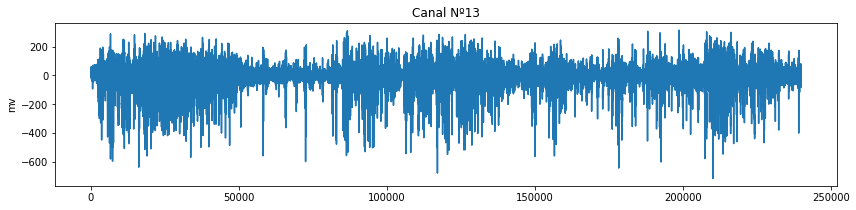

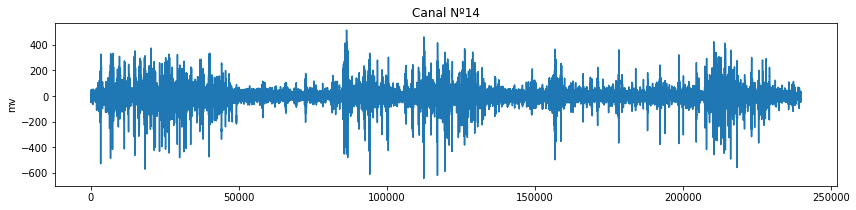

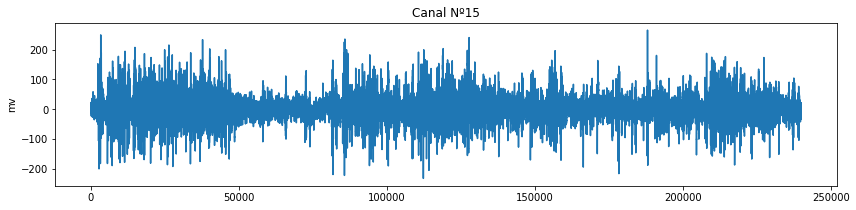

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

Mdata=dataStruct.data                     # matriz de datos
Ndata=np.size(Mdata,0)                    # numero de datos por canal
print('Numero de datos ' + str(Ndata))
sampf=dataStruct.iEEGsamplingRate         #sapling frequency
print('Fecuencia de Sampleo ' + str(sampf))
Nchan=len(dataStruct.channelIndices)       # numeros de canales 
print('Numero de Canales ' + str(Nchan))

for ichan in range(Nchan):
    plt.figure(num=ichan, figsize=(14,3))
    plt.plot(Mdata[:,ichan])
    plt.title('Canal Nº' + str(ichan))
    plt.ylabel('mv')


## **Filtrado**

Para todos los archivos se realizo un filtrado de pasa bandas para que para eliminar las bandas de freceuncias no deseadas. Para esto se utilizo un filtro butterwood entre las bandas [1 y 60] Hz




In [ ]:
import scipy.stats as sps
import scipy.signal as sp 
import scipy.io as spio
import numpy as np

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.lfilter(b, a, data)
    return y

MdataFilt=np.zeros((Ndata,Nchan))

for ichan in range(Nchan): 
    xfilt=butter_bandpass_filter(Mdata[:,ichan], 1, 60,   sampf, order=5)
    MdataFilt[:,ichan]=xfilt



In [ ]:
print(np.size(MdataFilt,0))

240000


Si comparamos la señal originial con la filtrada 

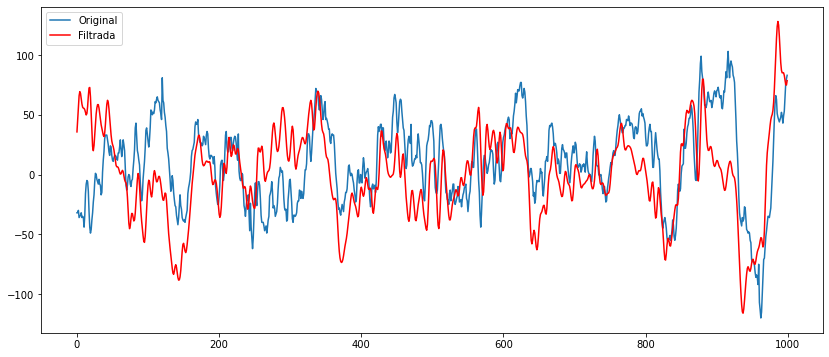

In [ ]:
plt.figure(num=1, figsize=(14,6))
plt.plot(Mdata[10000:11000,1],label='Original')  
plt.plot(MdataFilt[10000:11000,1],'r',label='Filtrada') 
plt.legend()


## Analisis 

Sobre cada una de las 16 señales de cada archivo se realizaron 8 analsis diferentes. 

*   Valor medio (Mean)
*   Desvio estandar  (Str)
*   Oblicuidad  (Skew)
*   Entropía de permutación (PE)
*   Complejidad Estadistica (SC)
*   Entropia Globlal de Redes (GNE)
*   Complejidad de Lempel Ziv (LZC)
*   Entropía Tsallis (STE)

Las 3 primeras son medias tradicionales calculadas sobre la señal y PE , SC y GNE son medidas de información sobre patrones de permutación, LZC es un medida de redundancia sobre una señal binaria y STE es la entropía sobre la distribución del frecuencias de la señal. 



## Medidas básicas de información

### Valor Medio , Desvio Estandar y Oblicuidad 

In [ ]:
vmedio=np.zeros((Nchan,1))
vstd=np.zeros((Nchan,1))
vskw=np.zeros((Nchan,1))

for ichan in range (Nchan):
  
    # Valor medio   
    vmedio[ichan]=np.mean(MdataFilt[ichan,:])
               
    #  Standard Desviation
    vstd[ichan]=np.std(MdataFilt[ichan,:])

    #  oblicuidad o  Skewnness   
    vskw[ichan]=sps.skew(MdataFilt[ichan,:])

# sacamos el valor medio sobre todos los 16 canales 
Medio=np.mean(vmedio)
print( 'Valor medio=' + str(Medio) )
Std=np.mean(vstd)
print( 'Desvio Estandar=' + str(Std) )
Skw=np.mean(vskw)
print( 'oblicuidad =' + str(Skw) )


Valor medio=-0.003769831613650177
Desvio Estandar=15.571214082488456
oblicuidad =0.39008408898978975


## Medidas de informacion sobre vectores de permutación

Para poder calcular las métricas de información antes mencionadas, primero se tienen que discretizar las señales de valores continuos (como tenemos las señales) a valores discretos (con alfabeto finito). Esto es necesario porque las métricas de información estan basadas en el cálculo de la distribución de probabilidad. Si bien existen muchos metodos para poder discretizar las señales, en este caso usaremos el de *patrones ordinales*.
A continuación se dará una explicación sobre como se pueden calcular cuantificar nuestras señales antes vistas en vectores de permutación. Luego veremos como calcular cada una de los cuantificadores. 



### Discretización de Series de Tiempo usando la aproximación Bandt-Pompe

El estudio de la caracterización de series de tiempo $\mathcal{X}(t)$, proveniente de herramientas de la teoría de la información, asume que el PDF se da a priori. Un problema similar ocurre en el contexto de la complejidad de Lempel-Ziv, donde es necesario tener una serie de tiempo discreta. En la literatura hay muchos métodos para cuantificar series de tiempo continuas como la binarización, histogramas o wavelet, entre otros. Sin embargo, un método efectivo que surge naturalmente es el introducido por Bandt y Pompe en el año 2002, llamados **vectores de perutación**

El metodo de permutación de vectores esta basado en los **valores relativos de los vecinos pertenecientes a la serie de tiempo**, y en consecuencia, toma en cuenta la estructura de tiempo o **causalidad del proceso** que genera dicha la secuencia. Para entender esta idea, consideremos una serie de tiempo en el dominio real discreto ${X}(t) = \{ x_t \in \mathbb{R} \}$, con $D \ge 2$ y $\tau \ge 1$ dos enteros llamados *dimensión de embedding* y *delay*, respectivamente.

De la serie de tiempo original, se introduce un vector con dimension $D$ $\mathbf{Y}^{(D,\tau)}_t$:

\begin{equation}
\mathbf{Y}_{t}^{(D,\tau)} \rightarrow  (x_{t-(D-1)\tau} , \dots , x_{t-\tau} , x_{t} )~ \qquad ~ {\mathrm {con}} ~\qquad ~ t \ge (D - 1)\tau  \ .
\end{equation}

El vector $\mathbf{Y}^{(D,\tau)}_t$ **preserva las propiedades dinamicas del sistema dinamico completo dependiendo de las condiciones de orden $D$ y $\tau$**. Los componentes de la fase de trayectoria de espacio $\mathbf{Y}^{(D,\tau)}_t$ se ordenan en orden ascendente. Luego, podemos definir un *vector de permutación*, $\mathbf{\Pi}^{(D,\tau)}_t$, con componentes dados por la posición original de los valores ordenados en orden ascendente. Cada uno de estos vectores representan un patrón (o motivo) con $D!$ posibles patrones. 

Para aclarar, damos un ejemplo. Supongamos que tenemos una serie de tiempo 

$\mathcal{X}(t)=\{0.32,~1.8,~5.4, ~0.25,~1.7 \}$ 

y tomamos los parametros $D3$ y $\tau=1$. Los vectores de embedding $\mathbf{Y}^{(D,\tau)}_t$ se definirían como 

$\mathbf{Y}^{(3,1)}_1=(0.32,1.8, 5.4)$  
$ \mathbf{Y}^{(3,1)}_2=(1.8,~5.4,~0.25)$  
$\mathbf{Y}^{(3,1)}_3=(5.4,~0.35,~1.7)$

Y los vectores de permutación correspondientes serian

$\mathbf{\Pi}^{(3,1)}_1=(0,~1,~2)$  
$\mathbf{\Pi}^{(3,1)}_2=(1,~2,~0)$  
$\mathbf{\Pi}^{(3,1)}_3=(2,~0,~1)$

Para entender como se aplican los cuantificadores de información a los vectores de permutación es necesario generar el rango de vectores PDF (Funcion de distribucion de probabilidad para obtener los vectores) y aplicar cada una de las distintas metricas. Por ejemplo, supongamos que tenemos una serie continua 

$\mathcal{X}=\{ 2.5,~0.7, ~1.1, ~3.1, ~2.7, ~1.4, ~2.3, ~ 1.5, ~1.1, ~0.7, ~0.8 \}$ 

y usamos el parametro BP $D=2$ y $\tau=1$, los vectores de embedding son 

$\mathbf{Y}^{(2,1)}_1=(2.5, 0.7)$,   $\mathbf{Y}^{(2,1)}_2=(0.7, 1.1)$  
$\mathbf{Y}^{(2,1)}_3=(1.1, 3.1)$,   $\mathbf{Y}^{(2,1)}_4=(3.1, 2.7)$  
$\mathbf{Y}^{(2,1)}_5=(2.7, 1.4)$,   $\mathbf{Y}^{(2,1)}_6=(1.4, 2.3)$  
$\mathbf{Y}^{(2,1)}_7=(2.3, 1.5)$,   $\mathbf{Y}^{(2,1)}_8=(1.5, 1.1)$  
$\mathbf{Y}^{(2,1)}_9=(1.1, 0.7)$,   $\mathbf{Y}^{(2,1)}_{10}=(0.7, 0.8)$  
 

Como $D = 2$, el alfabeto tiene tamaño $D! = 2$. Si el vector de permutación $\mathbf{\Pi}_0=(0,~1)$ se representa por 0 y $\mathbf{\Pi}_1=(1,~0)$ por 1, nuestra secuencia continua se cuantifica por 

$1~0~0~1~1~0~1~1~1~0$

[Video explicativo para armar vectores de permutacion de una serie de tiempo ](https://www.youtube.com/watch?v=LaTAq1NUTPE)


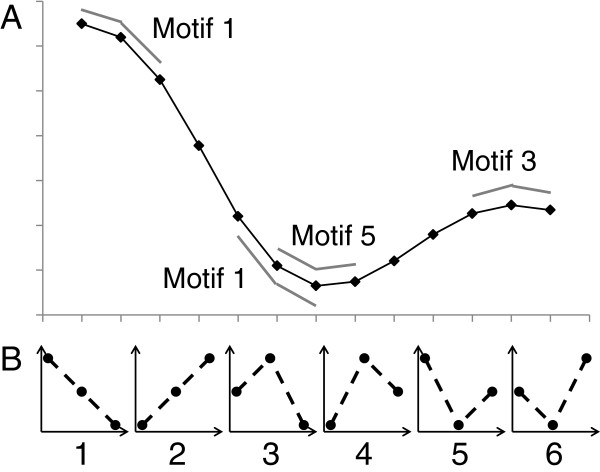


### Entropía de permutación (PE)

Dada una serie de tiempo $\mathcal{X}(t) \equiv  \{x_t ;~ t = 1, \cdots , N \}$, con $N$ observaciones, la metrica logaritmica de Shannon o **Entropía de Shannon** de la PDF asociada, $P \equiv  \{p_i ;~ i = 1, \cdots , M \}$ con $\sum _{i=1}^{M}p_i=1$ y $M$ la cantidad de estados posibles se define como: 

\begin{equation}
\mathcal{S}[P]~=~-\sum^{M}_{i=1} p_i \log(p_i) \ .
\end{equation}

Si podemos asegurar que nuestro sistema esta en el estado $i$, la probabilidad $p_i = 1$ y esta funcion es igual a cero. Por otro lado, cuando la probabilidad de distribición es uniforme, $P_u \equiv  \{p_i=1/M ; \forall i = 1, \cdots , M \}$, nuestro conocimiento sobre el sistema es minimo (todos los estados tienen la misma probabilidad) y la entropía llega a su máximo. 

Particularmente nuestra distribución de probabilidad va a venir dada por los vectores de permutación antes mencionados


### Complejidad Estadística (SC)

Si tomamos ambos extremos -orden perfecto (por ejemplo una secuencia periodica) y la maxima randomizacion (por ejemplo ruido blanco)- los dos son faciles de describir (por ejemplo el numero de bits) y tienen una complejidad cercana a 0 en ambos casos. En la distancia entre estos dos casos extremos existe un rango de posibles estructuras ordinales. Las metricas de complejidad estadistica permiten cuantificar estas posibilidades. En este caso vamos a considerar la complejidad de Martín-Plastino-Rosso (MPR) porque nos permite cuantificar detalles criticos del proceso dinamico en nuestro dataset

Basandonos en el trabajo de Lopez-Ruiz, la métrica de complejidad estadística de interes se define con el producto funcional

\begin{equation}
 \mathcal{C}[P]~=~{\mathcal Q}_J[P,P_e] \cdot \mathcal{H}[P]
 \end{equation}

de la entropia de Shannon normalizada: 

\begin{equation}
\mathcal{H}[P]~=~\mathcal{S}[P]/\mathcal{S}_{max} \ ,
\end{equation}

con $\mathcal{S}_{max}=\mathcal{S}[P_e]= \log N,$ ($0\leq \mathcal{H} \leq 1 $) y el desequilibrio ${\mathcal Q}_J$ definido en terminos la divergencia de *Jensen-Shannon*. Esto es, 
\begin{equation}
{\mathcal Q}_J[P,P_u]~=~\mathcal{Q}_0~\mathcal{J}[P,P_u] \ ,
\end{equation}
con:
\begin{equation}
\mathcal{J}[P,P_u]~=~\mathcal{S}[(P+P_u)/2]-\mathcal{S}[P]/2-\mathcal{S}[P_u]/2 \ ,
\end{equation}

La mencionada divergencia de Jensen-Shannon y la constante de normalizacion $\mathcal{Q}_0$, ($0 \leq \mathcal{Q}_J \leq 1 $) son iguales a la inversa del valor maximo posible para $\mathcal{J}[P,P_e]$. Este valor se obtiene cuando uno de los componentes del PDF, $P$, digamos $p_n$, es igual a uno y el resto de los $p_j$ es igual a cero.

La complejidad estadística depende de dos distribuciones de probabilidad diferentes. La asociada al sistema analizado, $P$, y la distribución uniforme, $P_u$. La distancia entre estas dos distribuciones de probabilidad se miden usando la divergencia de Jensen-Shannon. Ademas, se puede demostrar que para un valor de $\mathcal{H}$, el rango de posibles valores $\mathcal{C}$ varia entre un $\mathcal{C}_{min}$ y un $\mathcal{C}_{max}$, restringiendo los posibles valores de la complejidad estadística, dadu un plano de complejidad-entropía. A raíz de esto, la métrica de complejidad estadística puede aportar información importante relacionada a la estructura de correlación entre los componentes de nuestro sistema físico. 





### Entropia de Sallis (STE)

Además de la entropía de Shannon y la complejidad estadistica, se han investigado otras propuestas con otros cuantificadores de la distribución de probabilidad ordinal. Como ya verificamos para la complejidad estadistica, los distintos cuantificadores deberian extraer informacion adicional de una serie de tiempo dinamica que no estaría capturada por la entropía de permutación y la complejidad estadistica. En este contexto, una aproximacion valida es considerar generalizaciones de la entropía de Shannon parametrica, como la propuesta por Tsallis. Se define la entropía de permutación de Tsallis como

\begin{equation}
S_q (P)=\frac{1}{q-1}\sum_{i=1}^n (\rho_i(\Pi_i)-\rho_i(\Pi_i)^{q})
\end{equation}

Donde $P={\rho_i(\Pi_i)}_{i=1,...,n_{pi}}$ y $q$ es un parametro real ($q ⟶ 1)$ (recupera la entropía usual y por lo tanto la entropia de permutación). Por lo tanto, la entropia de Tsallis normalizada es

\begin{equation}
H_q(P)=(q-1)\frac{S_q(P)}{1-(n_{\pi})^{1-q}}
\end{equation}



###Entropia global de nodo (GNE)

[Ejemplo de red ordinal](https://www.researchgate.net/figure/Ordinal-network-approach-for-mapping-time-series-into-networks-a-Illustration-of-the_fig1_336251395)

El objetivo principal de mapear series de tiempo a redes ordinales es usar las diferentes redes medidas para caracterizar los datasets. Sin embargo, ademas de las estadisticas de redes derivadas de ciencia de redes, la naturaleza probabilistica inherente de los nodos y aristas en las redes ordinales fue la motivacion de dos metricas cetradas en la entropia. La primera es una medida local definida a nivel de nodo llamada entropía de nodo local.

\begin{equation}
s_i=-\sum_{j \in 𝒪}\rho'_{i,j}log(\rho'_{ij})
\end{equation}

donde el indice i refiere a un nodo de cierta peermutación $Π_i, ρ′_{i,j}= ρ_{i,j} / ∑_{k∈Oi} ρ_{i,k}$ representa la probabilidad normalizada de transicionar de un nodo i a un nodo j (permutaciones $Π_i$ and $Π_j$), y $O_i$ es el vecindario de salida del nodo i (aristas saliendo el nodo i). Esta cantidad mide el determinismo de las transacciones ordinales a nivel de nodo, de forma que $s_i$ es maximo cuando todas las aristas saliendo de i tienen el mismo peso, mientras $s_i = 0$ cuando hay una sola arista saliendo del nodo i. Basandonos en la entropia de nodo local, podemos definir la entropia de nodo global 

\begin{equation}
S_{GN}=-\sum_{i=1}^{n_{\pi}}\rho_is_i
\end{equation}

donde $ρ_i$ es la probabilidad de permitacion $Π_i$. Entonces, el valor $S_{GN}$ representa un promedio pesado del determinismo local sobre todos los nodos de una red ordinal (ver Unakafov y Keller para la definicion de la entropia condicional de patrones ordinales). 



In [ ]:
!pip install ordpy             # el Paquete ordpy calcula la PE SC y GNE de manera muy sencilla 



In [ ]:
import ordpy as op
from ordpy import complexity_entropy

vPE=np.zeros((Nchan,1))
vSC=np.zeros((Nchan,1))
vGNE=np.zeros((Nchan,1))
vSTE=np.zeros((Nchan,1))

for ichan in range (Nchan):
  
   #PErmutation Entropy (PE) and statistical complexity (SC)
      
    vPE[ichan],vSC[ichan]=complexity_entropy(MdataFilt[:,ichan], dx=4, taux=1, probs=False, tie_precision=None)
        
    #  Global node entropy   
    vGNE[ichan]=op.global_node_entropy(MdataFilt[:,ichan], dx=2)

    # Tsallis entropy q=2

    vSTE=[ichan]=op.tsallis_entropy(MdataFilt[:,ichan], q=[2],dx=4)

# sacamos el valor medio sobre todos los 16 canales 
PE=np.mean(vPE)
print( 'Etropia de permutación=' + str(PE) )
SC=np.mean(vSC)
print( 'Complejidad Estadística=' + str(SC) )
GNE=np.mean(vGNE)
print( 'Global Network Entropy =' + str(GNE) )
STE=np.mean(vSTE)
print( 'Stallis entropy  =' + str(STE) )



Etropia de permutación=0.563310754358112
Complejidad Estadística=0.28404053961644615
Global Network Entropy =0.0
Stallis entropy  =0.7589533624473588


In [ ]:
 vGNE=op.global_node_entropy(MdataFilt[:,1], dx=2)
 print(vGNE)

0.6778366226779602


###Complejidad de Lempel Ziv (LZC)

La complejidad de Lempel-Ziv es una forma diferente de analizar una secuencia. En este caso, no se basa en la PDF (Funcion de Distribucion de Probabilidad) de la  serie de tiempo $\mathcal{X}(t) \equiv  \{x_t ; t = 1, \cdots , N \}$, sino en la manera en la que $x_t$ se comporta en la secuencia. 

Para estimar la complejidad de $\mathcal{X}(t)$ vamos a usar el esquema propuesto por Lempel y Ziv en 1976. En esta aproximación, una secuencia $\mathcal{X}(t)$ se descompone en una cantidad de palabras $\mathcal{W}$ considerando cualquier subsecuencia que no se haya encontrado antes como una palabra nueva. La complejidad Lempel-Ziv $c_{LZ}$ es la minima cantidad de palabras $\mathcal{W}$ requerida para reconstruir la información contenida en la serie de tiempo original. 

Por ejemplo, la secuencia $100110111001010001011$ puede ser parseada en 7 palabras: $1 \cdot 0 \cdot 01 \cdot 101 \cdot 1100 \cdot 1010 \cdot 001011$, dando una complejidad de $c_{LZ}=7$. 


El LZC se puede normalizar basándose en la longitud N de la secuencia discreta y la longitud del alfabeto ($\alpha$) como

$$ \mathcal{C}_{LZ}=\frac{c_{LZ}[log_{\alpha}N]}{N}$$
 

In [ ]:
# para el analisis de LZC necesitamos el paquete antropy
!pip install antropy

     |████████████████████████████████| 49 kB 6.6 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=8345e8fa30b09526ae66a424ac9149186984d37ba93e839cb2649280e4374c5d
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy


In [ ]:
import antropy as ant

vLZC=np.zeros((Nchan,1))


for ichan in range (Nchan): 
    #Lempel Ziv complexity bin (LZC)
   
    th=np.mean(xfilt)
    lx=len(xfilt)
    xbin=np.zeros((lx))
    for i in range(lx):
        if xfilt[i] > th:
           xbin[i]=1
        
    vLZC[ichan]=ant.lziv_complexity(xbin, normalize=True)
        


# sacamos el valor medio sobre todos los 16 canales 
LZC=np.mean(vLZC)
print( 'Complejidad de Lempel Ziv=' + str(LZC) )



Complejidad de Lempel Ziv=0.18185446690675344
